### Fin 485 Midterm

In [99]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import scipy.stats
import datetime
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import arch

##### Question 1

In [100]:
class Question1:
    def __init__(self, tickers, start_date, end_date, _type_, frequency, statistics, histogram, real, portfolio):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self._type_ = _type_
        self.frequency = frequency
        self.statistics = statistics
        self.histogram = histogram
        self.real = real
        self.portfolio = portfolio
    
    def download_stocks(self):
        data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress = False)
        self.data = data['Adj Close']
        return self.data
    
    def calculate_returns(self, data):
        if self._type_ == "simple":
            returns = data.pct_change()
        elif self._type_ == "log":
            returns = np.log(self.data / self.data.shift(1))
        return returns
            
    def frequency_(self): 
        if self.frequency == "daily":
            return returns
        elif self.frequency == "weekly":
            returns = returns.resample("W").sum()
        elif self.frequency == "monthly":
            returns = returns.resample("M").sum()
        return returns
            
    def calculate_statistics(self, returns):
        if self.statistics == "yes":
            statistics_df = pd.DataFrame({
                "Average": returns.mean(),
                "Standard Deviation": returns.std(),
                "Variance": returns.var(),
                "Skewness": returns.skew(),
                "Kurtosis": returns.kurtosis(),
                "Minimum": returns.min(),
                "Maximum": returns.max()
            })
            return statistics_df
            print("Statistics: \n" , statistics_df)
        else:
            return None
    
    def plot_histogram(self, returns):
        if self.histogram == "yes":
            returns.hist(bins=30, alpha=0.5)
            plt.title("Histogram showing Sotck Returns")
            plt.xlabel("Returns")
            plt.ylabel("Frequency")
            plt.legend(self.tickers)
            plt.show()
            
    def calculate_real_returns(self, returns):
        if self.real == "yes":
            cpi_url = "https://pkgstore.datahub.io/core/cpi/cpi_csv/data/04cb8fe18892497287d23e20d0e1ceb9/cpi_csv.csv"
            cpi_data = pd.read_csv(cpi_url)
            cpi_data['Date'] = pd.to_datetime(cpi_data['Date'])

            merged_data = pd.merge(returns, cpi_data, left_index=True, right_on='Date', how='left')
            merged_data.set_index('Date', inplace=True)

            merged_data['Inflation_'] = merged_data['CPI'].pct_change()

            returns_real = returns.sub(merged_data['Inflation_'], axis=0)

            return returns_real
        else:
            return returns
        
    def calculate_portfolio_returns(self, returns):
        if self.portfolio == "ew":
            weights = [1 / len(self.tickers)] * len(self.tickers)
        elif self.portfolio == "vw":
            market_caps = list(input("Input market cap values:"))
            total_market_cap = sum(market_caps)
            weights = [cap / total_market_cap for cap in market_caps]

        portfolio_returns = (returns * weights).sum(axis=1)
 
        return portfolio_returns

Statistics:
       Average  Standard Deviation  Variance  Skewness  Kurtosis   Minimum   
AAPL -0.000970            0.022487  0.000506  0.316404  1.053219 -0.058680  \
AMZN -0.002232            0.031546  0.000995  0.240890  3.079613 -0.140494   
CHRW -0.000328            0.021447  0.000460 -0.530351  5.770759 -0.115043   
F    -0.001700            0.030986  0.000960 -0.054024  1.664394 -0.123242   
MSFT -0.001063            0.022245  0.000495  0.147841  0.893481 -0.077156   

       Maximum  
AAPL  0.088975  
AMZN  0.135359  
CHRW  0.084195  
F     0.116674  
MSFT  0.082268  


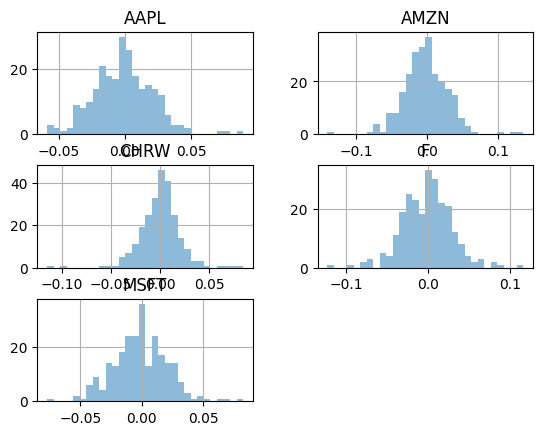

In [101]:
tickers = ['AAPL', 'MSFT', 'CHRW', 'AMZN', 'F']
start_date = '2021-12-31'
end_date = '2022-12-31'
type_ = 'simple'
frequency = 'daily'
statistics = 'yes'
histogram = 'yes'
real = 'no'
portfolio = 'vw'

results_1 = Question1(tickers, start_date, end_date, type_, frequency, statistics, histogram, real, portfolio)
data = results_1.download_stocks()
returns = results_1.calculate_returns(data)
statistics_results = results_1.calculate_statistics(returns)
print("Statistics:")
print(statistics_results)
results_1.plot_histogram(returns)

##### Question 2

In [104]:
class Question2:
    def __init__(self, tickers, start, end):
        self.tickers = tickers
        self.start = start
        self.end = end
        self.data = None
        self.returns = None
        self.betas = None
        self.signals = None
        self.positions = None
        self.strategy_returns = None

    def download_stocks(self):
        data= yf.download(self.tickers, start=self.start, end=self.end, progress=False)
        self.data = data['Adj Close'].resample('M').ffill().dropna()
        self.returns = self.data.pct_change()
        return self.data

    def calc_rolling_betas(self, window=30):
        betas = pd.DataFrame(index=self.returns.index)
        for ticker in self.tickers[:-1]:  
            betas[ticker] = RollingOLS(endog=self.returns[ticker], exog=self.returns['SPY'], window=30).fit().params
        self.betas = betas
        return self.betas

    def calc_signals(self):
        signal_max = self._signal_max(self.betas)
        signal_min = self._signal_min(self.betas)
        self.signals = signal_min + signal_max
        return self.signals

    def _signal_max(self, df):
        return df.apply(lambda x: x == x.max(), axis=1).astype(int)

    def _signal_min(self, df):
        return df.apply(lambda x: x == x.min(), axis=1).astype(int) * (-1)

    def calc_positions(self):
        self.positions = self.signals.diff()
        return self.positions

    def position_returns(self):
        strategy_each_stock = self.positions.dropna() * self.returns.drop('SPY', axis=1)
        self.strategy_returns = strategy_each_stock
        return self.strategy_returns

    def check_normal_dist(self):
        normality_test = pd.Series(np.random.normal(size=len(self.strategy_returns)))
        _, p_value = scipy.stats.normaltest(self.strategy_returns)
        is_normal = p_value > 0.05
        return is_normal

    def calculate_performance_metrics(self):
        average_return = self.strategy_returns.mean()
        standard_deviation = self.strategy_returns.std()
        sharpe_ratio = (self.strategy_returns.mean() / self.strategy_returns.std()) * np.sqrt(12)  # Assuming monthly data
        return average_return, standard_deviation, sharpe_ratio

    def plot_cumulative_returns(self):
        (1 + self.strategy_returns).cumprod().plot()  
        plt.title('Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.show()

Normal? [False False False False False False False False False False]
Average Return: 
 AAPL     0.000085
BA       0.003537
GOOGL    0.001865
GS       0.003113
JNJ      0.000563
JPM      0.000000
LMT      0.002203
MSFT     0.000807
UNH      0.002310
XOM      0.003757
dtype: float64 
 Standard Deviation:
 AAPL     0.030896
BA       0.067615
GOOGL    0.019859
GS       0.029851
JNJ      0.014814
JPM      0.000000
LMT      0.026911
MSFT     0.011626
UNH      0.021895
XOM      0.025604
dtype: float64 
 Sharpe Ratio:
  AAPL     0.009553
BA       0.181206
GOOGL    0.325311
GS       0.361277
JNJ      0.131646
JPM           NaN
LMT      0.283609
MSFT     0.240419
UNH      0.365439
XOM      0.508268
dtype: float64


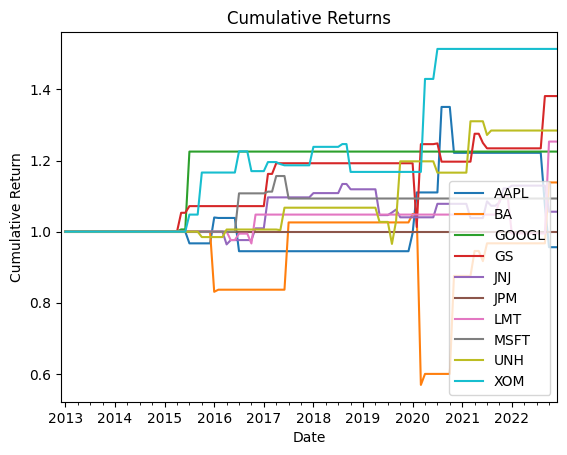

In [106]:
end = datetime.datetime(2022, 12, 31)
start = datetime.datetime(2012, 12, 31)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'XOM', 'JPM', 'GS', 'JNJ', 'UNH', 'BA', 'LMT', 'SPY']

results_2 = Question2(tickers, start, end)
results_2.download_stocks()
results_2.calc_rolling_betas()
results_2.calc_signals()
results_2.calc_positions()
results_2.position_returns()

is_normal = results_2.check_normal_dist()
print("Normal?", is_normal)

average_return, standard_deviation, sharpe_ratio = results_2.calculate_performance_metrics()
print("Average Return: \n", average_return, "\n Standard Deviation:\n", standard_deviation, "\n Sharpe Ratio:\n ", sharpe_ratio)

results_2.plot_cumulative_returns()

##### Question 3

In [107]:
class Question3:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.log_returns = None 

    def download_stocks(self):
        data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
        self.log_returns = {}
        for ticker in self.tickers:
            self.log_returns[ticker] = data['Adj Close'][ticker].pct_change().apply(lambda x: np.log(1 + x)).dropna()
        return data
    
    def stationarity_test(self):
        for ticker in self.tickers:
            adf_test = adfuller(self.log_returns[ticker])
            print(f"Based on the ADF test for {ticker}, the ADF statistic is {adf_test[0]} and the p-value is {adf_test[1]}")
    
    def plot_acf_pacf(self):
        for ticker in self.tickers:
            plt.figure(figsize=(10, 6))
            plot_acf(self.log_returns[ticker], lags=50, title=f'ACF - {ticker}')
            
            plt.figure(figsize=(10, 6))
            plot_pacf(self.log_returns[ticker], lags=50, title=f'PACF - {ticker}')
            plt.show()
            
    def fit_arima(self, data, order):
        model = ARIMA(data, order=order)
        fit = model.fit()
        return fit
    
    def fit_garch(self, residuals):
        model_g = arch.arch_model(residuals, vol='Garch', p=3, q=3)
        fit_g = model_g.fit()
        return fit_g
    
    def stock_tests(self):
        for ticker in self.tickers:
            stock_data = self.log_returns[ticker]

            p_value = self.stationarity_test()
            print(f'ADF test for {ticker}: p-value = {p_value}')

            self.plot_acf_pacf()

            ar_fit = self.fit_arima(stock_data, order=(3, 0, 0))
            if ar_fit.pvalues[3] < 0.05:
                print(f'{ticker}: AR(3) model is a good fit.')
            else:
                print(f'{ticker}: AR(3) model is not a good fit.')

            ma_fit = self.fit_arima(stock_data, order=(0, 0, 3))
            if ma_fit.pvalues[3] < 0.05:
                print(f'{ticker}: MA(3) model is a good fit.')
            else:
                print(f'{ticker}: MA(3) model is not a good fit.')

            arima_fit = self.fit_arima(stock_data, order=(3, 0, 3))
            if arima_fit.pvalues[3] < 0.05 and arima_fit.pvalues[6] < 0.05:
                print(f'{ticker}: ARIMA(3, 0, 3) model is a good fit.')
            else:
                print(f'{ticker}: ARIMA(3, 0, 3) model is not a good fit.')
        
        
            obs_size_train = 0.7
            obs_size_test = 1-obs_size_train
            train_size = int(len(stock_data) * obs_size_train)
            stock_train, stock_test = stock_data[:train_size], stock_data[train_size:]

        
            best_bic = float('inf')
            best_order = (0, 0, 0)
            for p in range(11):
                for q in range(11):
                    try:
                        model = fit_arima(stock_train, order=(p, 0, q))
                        fit = model.fit()
                        bic = fit.bic
                        if bic < best_bic:
                            best_bic = bic
                            best_order = (p, 0, q)
                    except:
                        continue

            print(f'Best ARIMA order for {ticker}:', best_order)
        
            arima_fit = self.fit_arima(stock_train, best_order)
            residuals = arima_fit.resid
            fig, ax = plt.subplots(2, 2, figsize=(12, 8))
            ax[0, 0].plot(residuals)
            sm.graphics.qqplot(residuals, line='s', ax=ax[0, 1])
            ax[1, 0].plot(residuals ** 2)
            sm.graphics.tsa.plot_acf(residuals ** 2, ax=ax[1, 1], fft=True)
            #plt.suptitle(f'Residuals and Diagnostics for ARIMA model of {ticker}')
            plt.show()
        
        
            normality_a= sm.stats.stattools.jarque_bera(residuals)
            print(f'Test for normality of residuals for {ticker}: p-value = {normality_a[1]}')
        
            hsk_test = sm.stats.diagnostic.het_arch(residuals)
            print(f'Test for heteroskedasticity of residuals for {ticker}: p-value = {hsk_test[1]}')
    
            if normality_a[1] < 0.05 or hsk_test[1] < 0.05:
                print(f'Residuals of ARIMA model for {ticker} do not satisfy usual regression assumptions.')
            else:
                print(f'Residuals of ARIMA model for {ticker} satisfy usual regression assumptions.')

        
            predictions_train = arima_fit.predict(start=0, end=len(stock_train)-1)
            predictions_test = arima_fit.forecast(steps=len(stock_test))
            #self.data['Forecasts'] = predictions_test
            
            print ('error free')
        

            all_data = pd.DataFrame({'StockTrain': stock_train, 'StockTest': stock_test})
            all_predictions = pd.concat([predictions_train, predictions_test], axis=0)
            all_data['Predictions'] = all_predictions
            all_data['Signal'] = all_data['Predictions'] > all_data.shift(1)['Adj Close']
            all_data['Actual_Return'] = all_data['Adj Close'].pct_change()
            all_data['Strategy_Return'] = all_data['Signal'].shift(1) * all_data['Actual_Return']

            all_data['Cumulative_Return'] = (1 + all_data['Strategy_Return']).cumprod()

            plt.plot(all_data['Cumulative_Return'])
            plt.title(f'Cumulative Returns for {ticker}')
            plt.show()
        
        # GARCH Fit and diagnostics
            garch_fit = self.fit_garch(arima_fit.resid) 

            residuals2 = garch_fit.resid
            fig, ax = plt.subplots(2, 2, figsize=(12, 8))
            ax[0, 0].plot(residuals2)
            sm.graphics.qqplot(residuals2, line='s', ax=ax[0, 1])
            ax[1, 0].plot(residuals2 ** 2)
            sm.graphics.tsa.plot_acf(residuals2 ** 2, ax=ax[1, 1], fft=True)
            #plt.suptitle(f'Residuals and Diagnostics for GARCH model of {ticker}')
            plt.show()
        
            normality = sm.stats.stattools.jarque_bera(residuals2)
            print(f'Test for normality of residuals for {ticker}: p-value = {normality[1]}')
        
            h_test = sm.stats.diagnostic.het_arch(residuals2)
            print(f'Test for heteroskedasticity of residuals for {ticker}: p-value = {h_test[1]}')
        
            if normality[1] < 0.05 or h_test[1] < 0.05:
                print(f'GARCH model is necessary for {ticker}.')
            else:
                print(f'GARCH model is not necessary for {ticker}.')

Based on the ADF test for AAPL, the ADF statistic is -15.025752636250388 and the p-value is 1.0070097695894437e-27
Based on the ADF test for MSFT, the ADF statistic is -16.926167272685348 and the p-value is 9.855608564042896e-30
Based on the ADF test for CHRW, the ADF statistic is -25.71529595764216 and the p-value is 0.0
Based on the ADF test for AMZN, the ADF statistic is -47.99415686794136 and the p-value is 0.0
Based on the ADF test for F, the ADF statistic is -13.940602185215194 and the p-value is 4.899794599849707e-26
ADF test for AAPL: p-value = None


<Figure size 1000x600 with 0 Axes>

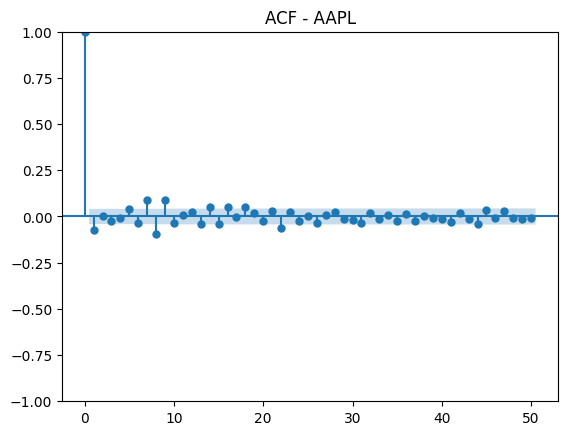

<Figure size 1000x600 with 0 Axes>

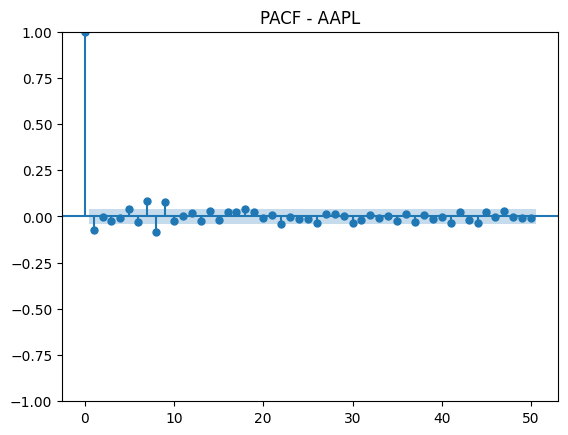

<Figure size 1000x600 with 0 Axes>

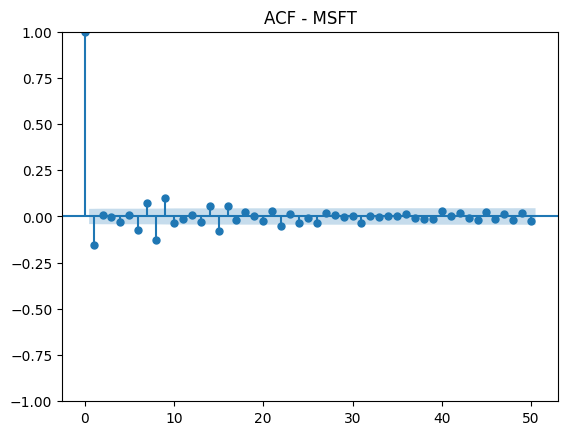

<Figure size 1000x600 with 0 Axes>

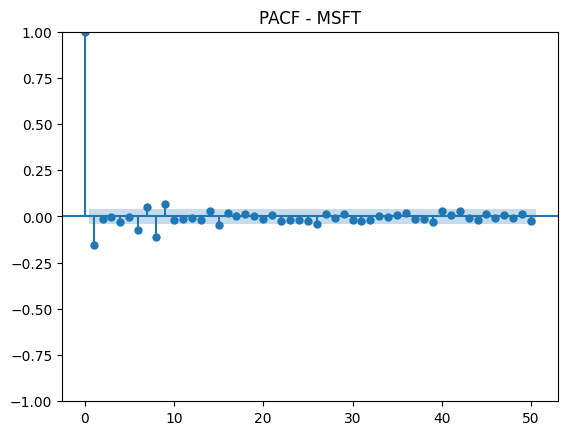

<Figure size 1000x600 with 0 Axes>

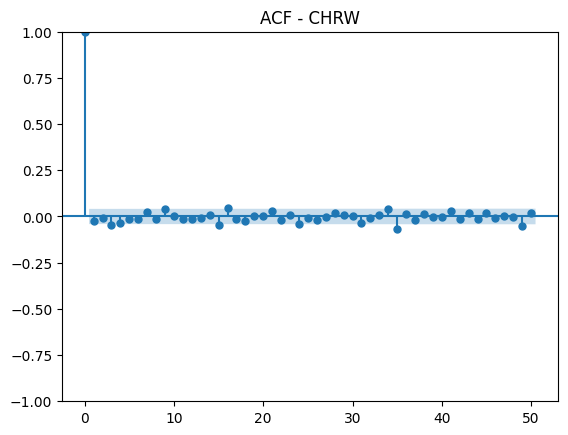

<Figure size 1000x600 with 0 Axes>

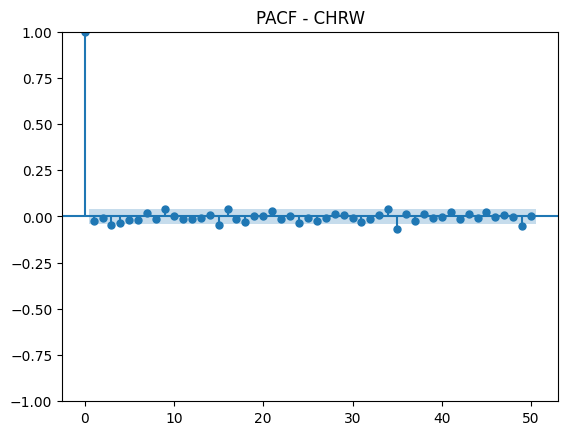

<Figure size 1000x600 with 0 Axes>

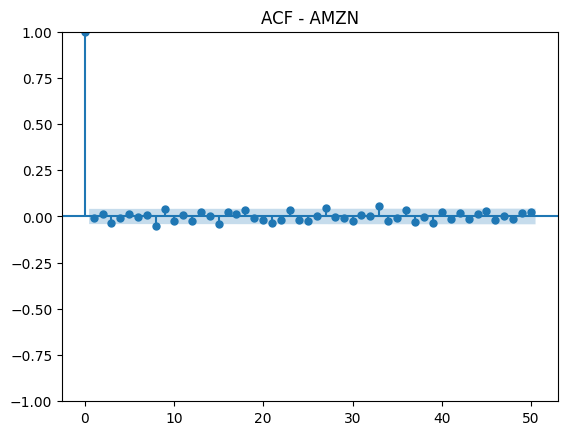

<Figure size 1000x600 with 0 Axes>

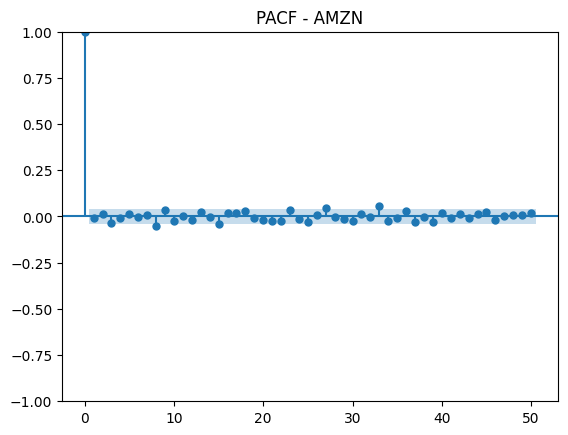

<Figure size 1000x600 with 0 Axes>

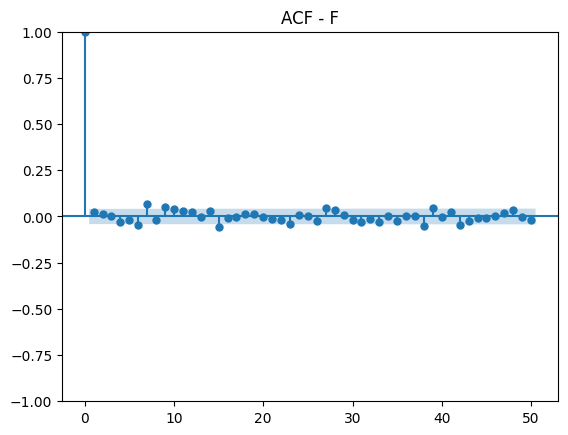

<Figure size 1000x600 with 0 Axes>

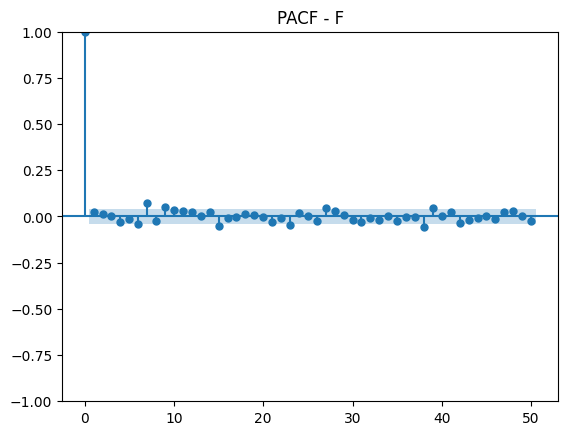

AAPL: AR(3) model is not a good fit.
AAPL: MA(3) model is not a good fit.
AAPL: ARIMA(3, 0, 3) model is not a good fit.
Best ARIMA order for AAPL: (0, 0, 0)


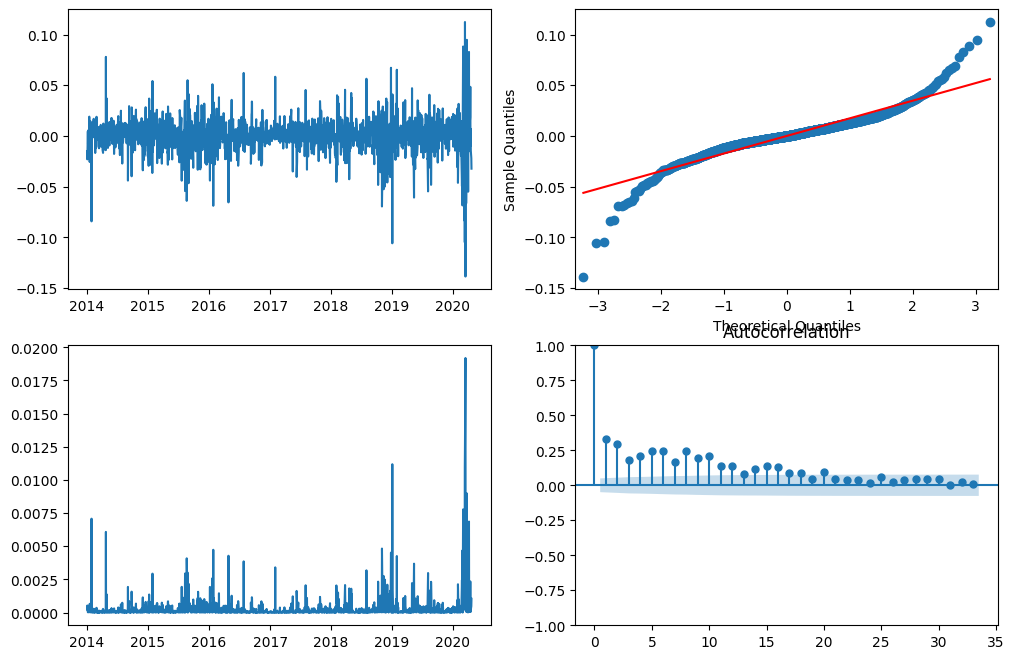

Test for normality of residuals for AAPL: p-value = 0.0
Test for heteroskedasticity of residuals for AAPL: p-value = 3.329207367121661e-62
Residuals of ARIMA model for AAPL do not satisfy usual regression assumptions.
error free


KeyError: 'Adj Close'

In [108]:
tickers = ['AAPL', 'MSFT', 'CHRW', 'AMZN', 'F']
start_date = '2013-12-31'
end_date = '2022-12-31'
q3 = Question3(tickers, start_date, end_date)
q3.download_stocks()
q3.stock_tests()

##### Question 4

The Fibonacci retracement technical analysis strategy uses Fibonacci ratios to identify potential support lines and resistance levels in a financial asset's price chart as well as place stop loss orders and set target prices. The strategy assumes that after a significant price movement, the asset's price is likely to retrace or pull back before continuing its original trend. The key Fibonacci ratios used are 23.6%, 38.2%, 50%, 61.8%, 78.6% and 100%. These levels represent the potential retracement areas, which are drawn as horizontal lines on the price chart. The strategy is created vy taking two extreme points ofn the chart and dividing the vertical distance by the ratios. Investors use the retracement levels to determine potential pull back points. which allows them to strategically enter or exit the market.

In [109]:
class Question4:
    def __init__(self, stock_prices):
        self.stock_prices = stock_prices
        self.signals = self.generate_signals()
        self.positions = self.calc_positions()
        self.strategy_returns = self.calc_strategy_returns()
        self.cumulative_returns = self.calc_cumulative_returns()

    def calc_fibonacci_levels(self, start_price, end_price):
        retracement_levels = [0.236, 0.382, 0.500, 0.618, 0.786]
        price_diff = abs(end_price - start_price)
        fibonacci_levels = [end_price - level * price_diff for level in retracement_levels]
        return fibonacci_levels

    def generate_signals(self):
        signals = []
        in_position = False
        for i in range(1, len(self.stock_prices)):
            if self.stock_prices[i] > self.stock_prices[i - 1]:
                # Uptrend, check for Buy signal
                fibonacci_levels = self.calc_fibonacci_levels(self.stock_prices[i - 1], self.stock_prices[i])
                for level in fibonacci_levels:
                    if self.stock_prices[i] <= level:
                        signals.append(1)  # Buy signal
                        in_position = True
                        break
                if not in_position:
                    signals.append(0)  # No signal
            elif self.stock_prices[i] < self.stock_prices[i - 1]:
                # Downtrend, check for Sell signal
                fibonacci_levels = self.calc_fibonacci_levels(self.stock_prices[i - 1], self.stock_prices[i])
                for level in fibonacci_levels:
                    if self.stock_prices[i] >= level:
                        signals.append(-1)  # Sell signal
                        in_position = False
                        break
                if in_position:
                    signals.append(0)  # No signal
            else:
                signals.append(0)  # No signal
        return signals

    def calc_positions(self):
        positions = [self.signals[i] - self.signals[i - 1] for i in range(1, len(self.signals))]
        return positions

    def calc_strategy_returns(self):
        strategy_returns = [position * self.stock_prices[i + 1] / self.stock_prices[i]
                            for i, position in enumerate(self.positions)]
        return strategy_returns

    def calc_cumulative_returns(self):
        cumulative_return = 1
        cumulative_returns = [cumulative_return]
        for strategy_return in self.strategy_returns:
            cumulative_return *= (1 + strategy_return)
            cumulative_returns.append(cumulative_return)
        return cumulative_returns

ValueError: x and y must have same first dimension, but have shapes (249,) and (0, 250)

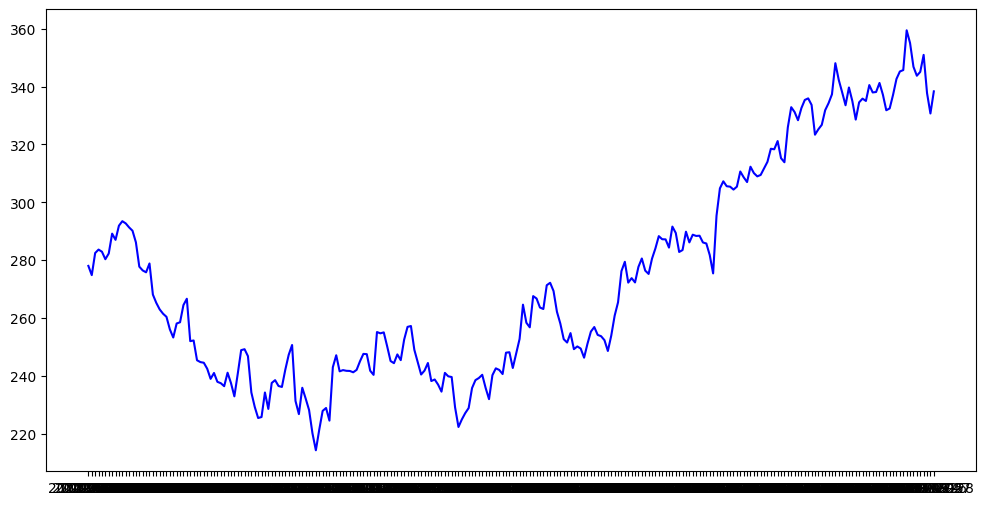

In [110]:
company_a = pd.read_csv(r"C:\Users\keann\OneDrive\FIN 485\MSFT.csv")
company_b = pd.read_csv(r"C:\Users\keann\OneDrive\FIN 485\AAPL.csv")


strategy_company_a = Question4(company_a['Adj Close'].values)
strategy_company_b = Question4(company_b['Adj Close'].values)

plt.figure(figsize=(12, 6))
plt.plot(company_a['Date'], company_a['Close'], label='Company A Close Price', color='blue')
plt.plot(company_a['Date'][1:], strategy_company_a.stock_prices[strategy_company_a.signals == 1],
         '^', markersize=10, color='g', label='Buy Signal')
plt.plot(company_a['Date'][1:], strategy_company_a.stock_prices[strategy_company_a.signals == -1],
         'v', markersize=10, color='r', label='Sell Signal')
plt.title('Company A Trading Signals')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(company_a['Date'][1:], strategy_company_a.cumulative_returns, label='Company A', color='blue')
plt.title('Company A Strategy Cumulative Returns')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plotting the signals and cumulative returns for Company B
plt.figure(figsize=(12, 6))
plt.plot(company_b['Date'], company_b['Close'], label='Company B Close Price', color='blue')
plt.plot(company_b['Date'][1:], strategy_company_b.stock_prices[strategy_company_b.signals == 1],
         '^', markersize=10, color='g', label='Buy Signal')
plt.plot(company_b['Date'][1:], strategy_company_b.stock_prices[strategy_company_b.signals == -1],
         'v', markersize=10, color='r', label='Sell Signal')
plt.title('Company B Trading Signals')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(company_b['Date'][1:], strategy_company_b.cumulative_returns, label='Company B', color='blue')
plt.title('Company B Strategy Cumulative Returns')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


##### Question 5

In [111]:
class Question5:
    def __init__(self, stock1, stock2, start_date, end_date, rolling_window=60, strategy_window=12):
        self.stock1 = stock1
        self.stock2 = stock2
        self.start_date = start_date
        self.end_date = end_date
        self.rolling_window = rolling_window
        self.strategy_window = strategy_window


    def download_data(self):
        #self.data1 = yf.download(self.stock1, start=self.start_date, end=self.end_date)['Adj Close']
        #self.data2 = yf.download(self.stock2, start=self.start_date, end=self.end_date)['Adj Close']
        #data = pd.concat[self.data1, self.data2]
        
        df = yf.download([self.stock1, self.stock2], start=self.start_date, end=self.end_date, progress=False)
        data = df['Adj Close'].dropna()
        return data

    def calc_monthly_returns(self):
        #self.returns1 = self.data1.pct_change().dropna()
        #self.returns2 = self.data2.pct_change().dropna()
        
        data2 = data.pct_change()

    def calc_rolling_correlation(self):
        self.rolling_corr = self.returns1.rolling(self.rolling_window).corr(self.returns2)

    def calc_rolling_avg_returns(self):
        self.rolling_avgreturns1 = self.returns1.rolling(self.rolling_window).mean()
        self.rolling_avgreturns2 =  self.returns2.rolling(self.rolling_window).mean()
        print(f" {self.rolling_avgreturns1} : {self.stock1}")
    
    def calc_avg_and_std_dev(self):
        self.avg_corr = self.rolling_corr.mean()
        self.std_corr = self.rolling_corr.std()

    def trading_rules(self, data):
        self.sell = self.avg_corr - self.std_corr
        self.buy = self.avg_corr + self.std_corr
        
        signals = pd.Series(0, index=data.index)
        for i in range(1, len(signals)):
            if self.rolling_corr.iloc[i - 1] > self.buy:
                signals.iloc[i] = 1 
            elif self.rolling_corr.iloc[i - 1] < self.sell:
                signals.iloc[i] = -1  
            else:
                signals.iloc[i] = signals.iloc[i - 1]
        return signals
  

    def calc_strategy_returns(self, data, signals):
        strategy_returns = pd.Series(0, index=data.index)
        strategy_returns[self.stock1] = data[self.stock1].shift(1) * self.rolling_avgreturns1
        strategy_returns[self.stock2] = data[self.stock2].shift(1) * self.rolling_avgreturns2
        stategy_returns['returns'] =  strategy_returns.sum(axis=1)
        return strategy_returns

    def calc_rolling_strategy_returns(self, strategy_returns):
        rolling_strategy_returns = strategy_returns['returns'].rolling(window=12).sum().dropna()
        return rolling_strategy_returns
        
        #self.strategy_rolling_returns = self.strategy_returns.rolling(self.strategy_window).sum()

    def calc_strategy_sharpe_ratio(self, rolling_strategy_returns):
        rolling_sharpe_ratio = (rolling_strategy_returns.mean() / rolling_strategy_returns.std()) * np.sqrt(12)
        return rolling_sharpe_ratio
        #self.strategy_sharpe_ratio = (self.strategy_rolling_returns.mean() / self.strategy_rolling_returns.std()) * np.sqrt(12)

    def plot_cumulative_returns(self, strategy_returns):
        return (1 + strategy_returns['returns']).cumprod().plot()


    def plot_rolling_sharpe_ratio(self, rolling_strategy_returns):
        return rolling_strategy_returns.plot()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


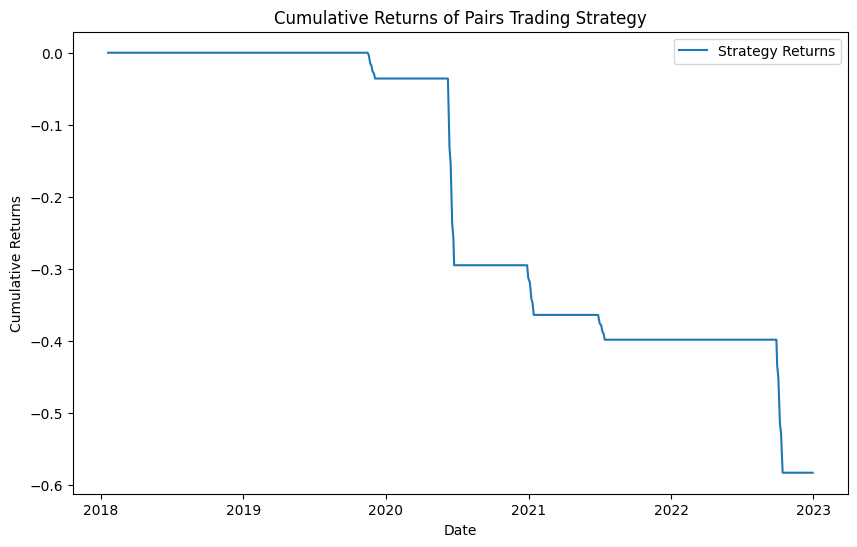

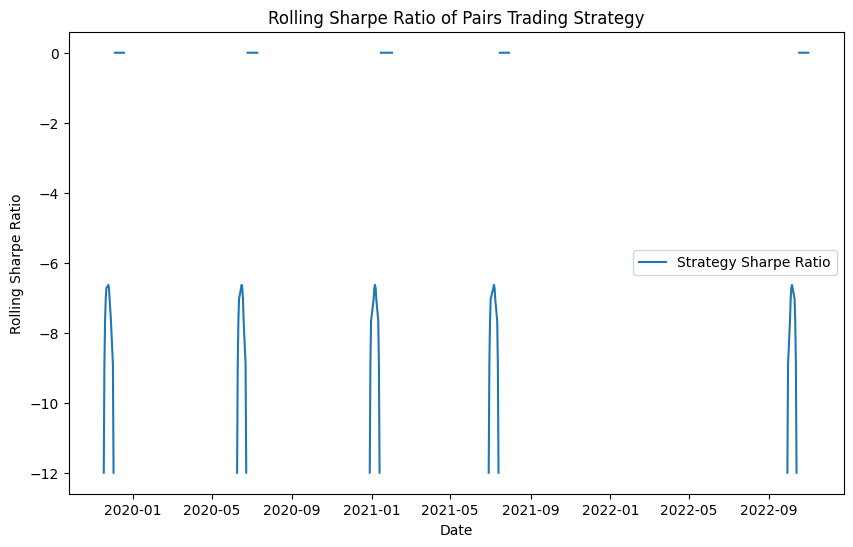

Average Correlation: -0.0047
Standard Deviation of Correlation: 0.0930


In [112]:
if __name__ == "__main__":
    strategy = PairsTradingStrategy('AAPL', 'SSNLF', '2018-01-01', '2023-01-01')
    strategy.download_data()
    strategy.calculate_monthly_returns()
    strategy.calculate_rolling_correlation()
    strategy.calculate_rolling_average_returns()
    strategy.calculate_stats()
    strategy.set_trading_signals()
    strategy.calculate_strategy_returns()
    strategy.calculate_rolling_strategy_returns()
    strategy.calculate_rolling_strategy_sharpe_ratio()
    strategy.plot_cumulative_returns()
    strategy.plot_rolling_sharpe_ratio()
    strategy.interpret_results()